In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

print("Path to dataset files:", path)

100%|██████████| 1.15G/1.15G [00:05<00:00, 229MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7


In [2]:
import os
print("Main structure:", os.listdir(path))
base_dir = os.path.join(path, 'Infection Segmentation Data', 'Infection Segmentation Data')
train_dir = os.path.join(base_dir, 'Train')

if os.path.exists(train_dir):
    print("Train directory exists:", os.listdir(train_dir))
else:
    print("Please check the structure again using os.listdir(path) above")

Main structure: ['COVID-QU-Ex dataset.txt', 'Lung Segmentation Data', 'Infection Segmentation Data']
Train directory exists: ['Non-COVID', 'Normal', 'COVID-19']


In [ ]:
from pathlib import Path
data_root = Path(path) / "Lung Segmentation Data" / "Lung Segmentation Data"
print(f"path: {data_root}")

if data_root.exists():
    print("find")
else:
    print("not find")
train_data = get_file_paths(data_root, split="Train")

path: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Lung Segmentation Data/Lung Segmentation Data
find
Train - COVID-19: Found 7658 images.
Train - Non-COVID: Found 7208 images.
Train - Normal: Found 6849 images.


In [6]:
from pathlib import Path
data_root = Path(path) / "Lung Segmentation Data" / "Lung Segmentation Data"
print(f"Actual path: {data_root}")

if data_root.exists():
    print("Root directory found!")
else:
    print("Directory not found. Please re-run the dataset download cell above to get the 'path' variable.")
train_data = get_file_paths(data_root, split="Train")

Actual path: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Lung Segmentation Data/Lung Segmentation Data
Root directory found!
Train - COVID-19: Found 7658 images.
Train - Non-COVID: Found 7208 images.
Train - Normal: Found 6849 images.


In [16]:
from pathlib import Path

data_root = Path(path) / "Lung Segmentation Data" / "Lung Segmentation Data"

def get_all_paths(root, split="Train"):
    categories = ["COVID-19", "Non-COVID", "Normal"]
    imgs, masks = [], []
    for cat in categories:
        img_dir = root / split / cat / "images"
        mask_dir = root / split / cat / "lung masks"
        # Sort to ensure images and masks always match
        imgs.extend(sorted(list(img_dir.glob("*.png"))))
        masks.extend(sorted(list(mask_dir.glob("*.png"))))
    return imgs, masks

# Initialize missing variables from your image
train_imgs, train_masks = get_all_paths(data_root, "Train")
val_imgs, val_masks = get_all_paths(data_root, "Val")

print(f"Identified: {len(train_imgs)} training images and {len(val_imgs)} validation images.")

Identified: 21715 training images and 5417 validation images.


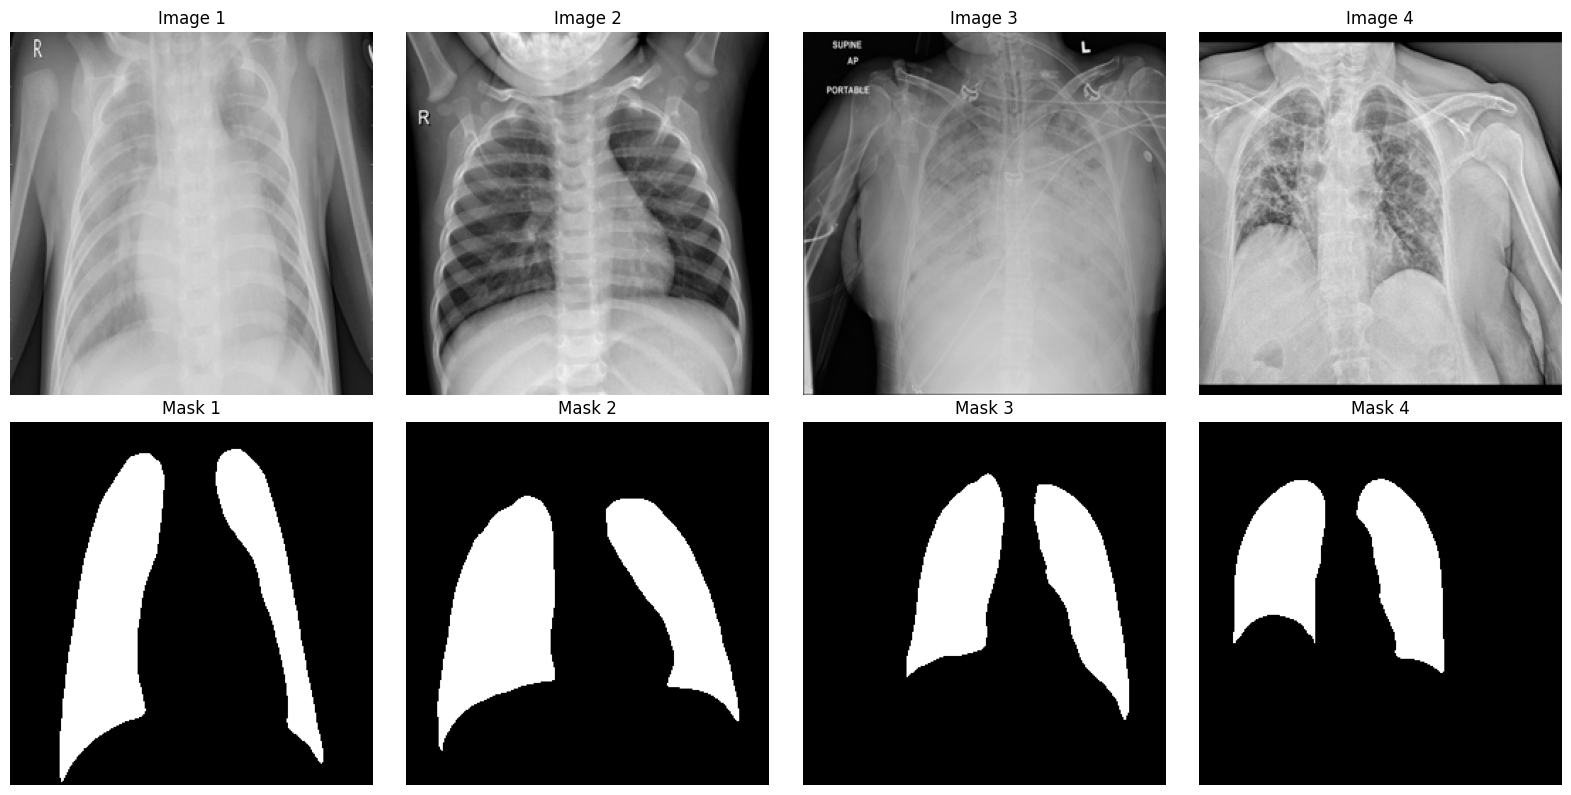

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_4_samples(data_map):
    plt.figure(figsize=(16, 8))
    all_images = data_map['COVID-19']['images'] + data_map['Non-COVID']['images'] + data_map['Normal']['images']
    all_masks = data_map['COVID-19']['masks'] + data_map['Non-COVID']['masks'] + data_map['Normal']['masks']

    # random image
    indices = random.sample(range(len(all_images)), 4)

    for i, idx in enumerate(indices):
        img = Image.open(all_images[idx])
        mask = Image.open(all_masks[idx])

        # plot
        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # show the masj in dataset
        plt.subplot(2, 4, i + 5)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_4_samples(train_data)


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class COVIDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        mask = (mask > 0.5).float()

        return image, mask

In [11]:
#transforms

In [12]:
import torchvision.transforms as T
image_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

In [17]:
from torch.utils.data import DataLoader

# Initialize Dataset
train_dataset = COVIDDataset(train_imgs, train_masks, image_transforms, mask_transforms)
val_dataset = COVIDDataset(val_imgs, val_masks, image_transforms, mask_transforms)

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
images, masks = next(iter(train_loader))
print(f"Image batch size: {images.shape}")
print(f"Mask batch size: {masks.shape}")

Image batch size: torch.Size([16, 3, 256, 256])
Mask batch size: torch.Size([16, 1, 256, 256])


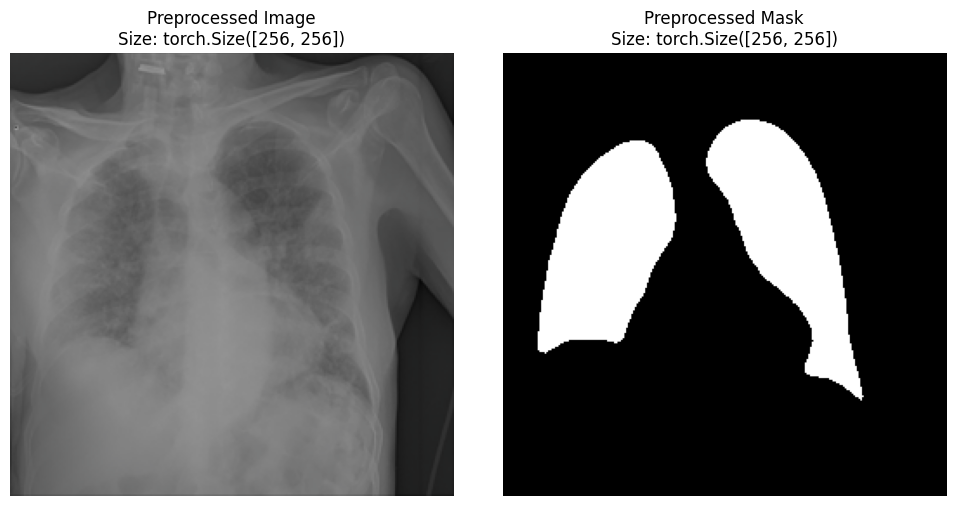

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def show_preprocessed_batch(dataloader):
    # Get one batch of images and masks
    images, masks = next(iter(dataloader))

    # Choose the first image in the batch
    img = images[0]
    mask = masks[0]

    # Convert image from Tensor [C, H, W] to Numpy [H, W, C] for plotting
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # Reverse Normalization for visualization purposes
    # (Since we used mean=0.485 and std=0.229 during preprocessing)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1) # Ensure values are within [0, 1]

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot Preprocessed Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Preprocessed Image\nSize: {img.shape[1:]}")
    plt.axis('off')

    # Plot Preprocessed Mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Preprocessed Mask\nSize: {mask.shape[1:]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
show_preprocessed_batch(train_loader)

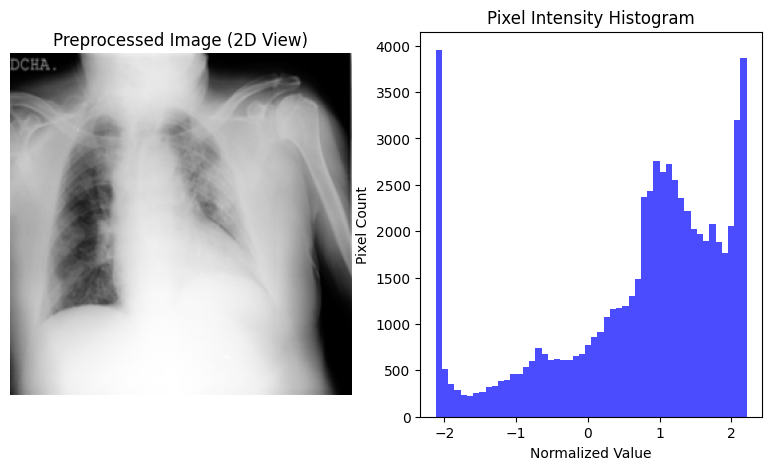

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_2d_analysis(dataset, index=0):
    image, mask = dataset[index]

    # Convert tensor to numpy
    img_np = image[0].cpu().numpy() # Take 1st channel

    plt.figure(figsize=(15, 5))

    # Subplot 1: Original Preprocessed Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Preprocessed Image (2D View)")
    plt.axis('off')

    # Subplot 2: Pixel Intensity Distribution (Histogram)
    plt.subplot(1, 3, 2)
    plt.hist(img_np.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Normalized Value")
    plt.ylabel("Pixel Count")

# Run 2D analysis
visualize_2d_analysis(train_dataset, index=10)

In [25]:
import torch
import torch.nn as nn
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        # First convolution layer
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels), # Added for training stability
        nn.ReLU(inplace=True),

        # Second convolution layer
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )




In [31]:
import torch
import torch.nn as nn

class UNetFromScratch(nn.Module):
    def __init__(self):
        super(UNetFromScratch, self).__init__()
        # Level 1: Input 3 channels (RGB) -> Output 64
        self.enc1 = double_conv(3, 64)

        # Level 2: Input 64 -> Output 128
        self.enc2 = double_conv(64, 128)

        # Level 3: Input 128 -> Output 256
        self.enc3 = double_conv(128, 256)

        # Level 4: Bottleneck (The base of the U)
        self.bottleneck = double_conv(256, 512)

        # Max Pooling to reduce spatial dimensions (H, W) by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Level 3 Up: Transpose convolution to double the size
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # Process concatenated features (256 from up + 256 from skip connection)s
        self.dec3 = double_conv(512, 256)

        # Level 2 Up
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = double_conv(256, 128)

        # Level 1 Up
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = double_conv(128, 64)

        # Final 1x1 Convolution to get a single channel output (Mask)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Level 1
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        # Level 2
        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Level 3
        e3 = self.enc3(p2)
        p3 = self.pool(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Level 3 Up + Skip Connection
        d3 = self.up3(b)
        d3 = torch.cat((d3, e3), dim=1) # Concatenate along channels
        d3 = self.dec3(d3)

        # Level 2 Up + Skip Connection
        d2 = self.up2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        # Level 1 Up + Skip Connection
        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        # Final Output Layer
        output = self.final_conv(d1)

        # Sigmoid activation to squeeze output between 0 and 1 (Probability)
        return torch.sigmoid(output)

In [33]:
# Initialize model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetFromScratch().to(device)

In [34]:
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
def dice_coeff(pred, target):
    smooth = 1.0
    num = 2.0 * torch.sum(pred * target) + smooth
    den = torch.sum(pred) + torch.sum(target) + smooth
    return num / den

In [35]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        model.eval()
        total_val_dice = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)

                total_val_dice += dice_coeff(outputs, masks).item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_dice = total_val_dice / len(val_loader)

        print(f"Result -> Train Loss: {avg_train_loss:.4f} | Val Dice Score: {avg_val_dice:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch 1/5: 100%|██████████| 1358/1358 [03:15<00:00,  6.94it/s]


Result -> Train Loss: 0.1223 | Val Dice Score: 0.9156


Epoch 2/5: 100%|██████████| 1358/1358 [03:13<00:00,  7.03it/s]


Result -> Train Loss: 0.0437 | Val Dice Score: 0.9486


Epoch 3/5: 100%|██████████| 1358/1358 [03:12<00:00,  7.04it/s]


Result -> Train Loss: 0.0333 | Val Dice Score: 0.9572


Epoch 4/5: 100%|██████████| 1358/1358 [03:13<00:00,  7.02it/s]


Result -> Train Loss: 0.0298 | Val Dice Score: 0.9623


Epoch 5/5: 100%|██████████| 1358/1358 [03:13<00:00,  7.02it/s]


Result -> Train Loss: 0.0282 | Val Dice Score: 0.9656


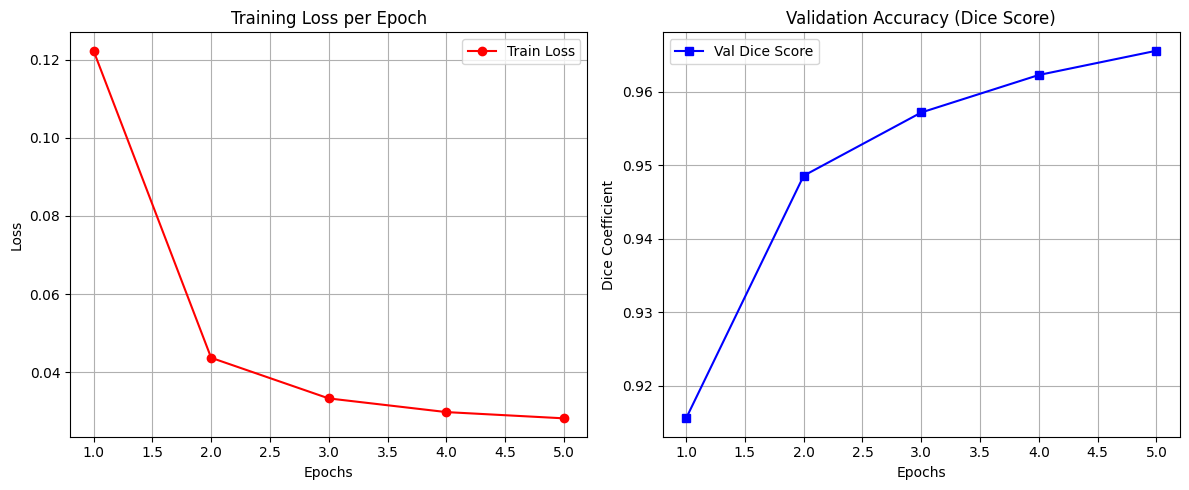

In [38]:
import matplotlib.pyplot as plt
epochs = range(1, 6)
train_losses = [0.1223, 0.0437, 0.0333, 0.0298, 0.0282]
val_dice_scores = [0.9156, 0.9486, 0.9572, 0.9623, 0.9656]

def plot_training_history(losses, dice_scores):
    plt.figure(figsize=(12, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r-o', label='Train Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Validation Dice Score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, dice_scores, 'b-s', label='Val Dice Score')
    plt.title('Validation Accuracy (Dice Score)')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Execute the plot
plot_training_history(train_losses, val_dice_scores)

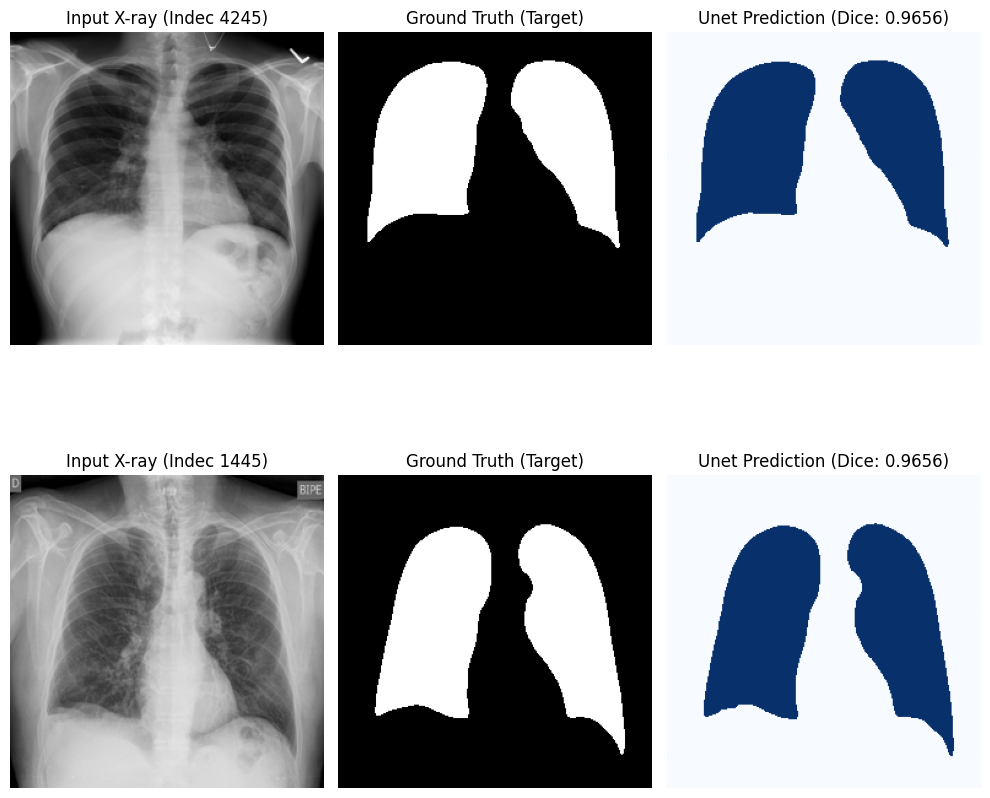

In [52]:
import matplotlib.pyplot as plt
import torch

def show_model_output(model, dataset, num_samples=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a plot with 3 columns: Input, Target, Prediction
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 5))

    # Define denormalization parameters
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(num_samples):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, mask = dataset[idx]

        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            prediction = model(input_tensor).cpu().squeeze()
            binary_pred = (prediction > 0.5).float()

        # Denormalize image for display
        img_display = image * std + mean
        img_display = img_display.permute(1, 2, 0).numpy().clip(0, 1)

        # Plot Input Image
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"Input X-ray (Indec {idx})")
        axes[i, 0].axis('off')

        # Plot Ground Truth (The label)
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth (Target)")
        axes[i, 1].axis('off')

        # Plot Model Prediction
        axes[i, 2].imshow(binary_pred, cmap='Blues')
        axes[i, 2].set_title(f"Unet Prediction (Dice: {val_dice_scores[-1]:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization for 2 random samples
show_model_output(model, val_dataset, num_samples=2)

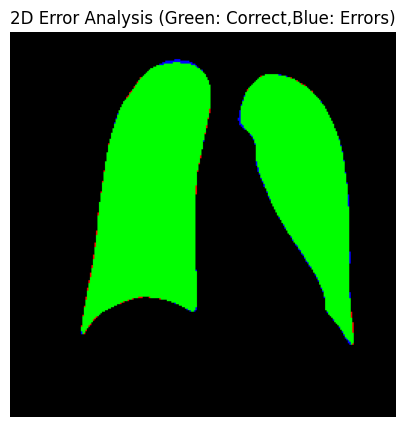

In [51]:
def show_2d_comparison(model, dataset, index=0):
    model.eval()
    image, mask = dataset[index]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).cpu().squeeze()
        pred_binary = (pred > 0.5).float()

    #true positie = green
    #not true + blue
    overlap = np.zeros((256, 256, 3))
    mask_np = mask.squeeze().numpy()
    pred_np = pred_binary.numpy()

    overlap[(mask_np == 1) & (pred_np == 1)] = [0, 1, 0]
    overlap[(mask_np == 0) & (pred_np == 1)] = [1, 0, 0]
    overlap[(mask_np == 1) & (pred_np == 0)] = [0, 0, 1]

    plt.figure(figsize=(10, 5))
    plt.imshow(overlap)
    plt.title("2D Error Analysis (Green: Correct,Blue: Errors)")
    plt.axis('off')
    plt.show()

show_2d_comparison(model, val_dataset, index=25)